In [ ]:
# TODO: Add !pip install command

# Imports

The code above imports various Python modules and libraries for data processing, visualization, and analysis. Below is a description of each module and library imported:

- `os`: Provides a way to interact with the operating system, such as navigating directories and working with files.
- `ast`: Provides a way to parse Python code into an abstract syntax tree, which can be used to analyze and manipulate the code.
- `spacy`: A library for natural language processing, including tasks such as tokenization, part-of-speech tagging, and named entity recognition.
- `folium`: A library for creating interactive maps using the Leaflet JavaScript library.
- `sqlite3`: A module for working with SQLite databases.
- `squarify`: A library for generating treemaps, which visualize hierarchical data using nested rectangles.
- `itertools`: Provides a collection of functions for working with iterators, such as combining multiple iterators or creating permutations.
- `webcolors`: A library for working with CSS-style color strings.
- `tqdm`: A library for creating progress bars for loops.
- `pandas`: A library for data manipulation and analysis, including reading and writing data to/from various file formats.
- `ipywidgets`: Provides interactive widgets for Jupyter notebooks and other IPython environments.
- `matplotlib.pyplot`: A library for creating visualizations, including line plots, scatter plots, bar charts, and histograms.
- `collections.Counter`: A container that keeps track of the frequency of elements in a collection.

In [82]:
import os
import ast
import geopy
import spacy
import folium
import sqlite3
import datetime
import squarify
import itertools
import webcolors
import numpy as np
import pandas as pd
from tqdm import tqdm
import ipywidgets as widgets
from collections import Counter
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from dotenv import load_dotenv
load_dotenv()

True

# Settings base variables and paths

The code above sets the base folder path and creates four subdirectories within that base path: "images", "metadata", and "config". These subdirectories are created by joining the base path with their respective names using the os.path.join() function.

In [83]:
# Set the base folder path for the project
output_path = "../output"
images_path = os.path.join(output_path, "images")
metadata_path = os.path.join(output_path, "metadata")
config_path = os.path.join(output_path, "config")

list_of_paths = [output_path, images_path, metadata_path, config_path]


# Set SQL variables
sql_host = os.getenv("SQL_HOST")
sql_user = os.getenv("SQL_USER")
sql_password = os.getenv("SQL_PASSWORD")
sql_database = os.getenv("SQL_DATABASE")

# Get the metadata from db and sort it with list into a dictionary

### Get the metadata from the database

The function "get_metadata_from_sqlite_DB" is used to retrieve metadata from a SQLite database. It takes an optional argument "db_name" to specify the name of the database. It opens a connection to the database, creates a cursor, and retrieves metadata for the first file in the images' directory. The metadata is stored in a dictionary format, where the filename is the key and the metadata is a list of key-value pairs. The function then closes the connection and returns the dictionary of metadata.

In [84]:
def get_metadata_from_sqlite_db(db_name='metadata.db') :
    """
    Get the metadata from the sqlite database

    :param db_name: The name of the database
    :return: A dictionary with the metadata
    """
    # Open a connection to the database
    conn = sqlite3.connect(os.path.join(metadata_path, db_name))
    # Create a cursor
    c = conn.cursor()

    # Retrieve the metadata
    c.execute("""
        SELECT filename, GROUP_CONCAT(key || '\t' || value, '\n') AS metadata
        FROM metadata
        GROUP BY filename;
    """)
    metadata = c.fetchall()

    # Close the connection
    conn.close()

    # Convert the metadata to a DataFrame
    result = {}
    for image in tqdm(metadata, desc="Get metadata from database"):
        try :
            result[image[0]] = {}
            props = image[1].split('\n')
            for prop in props:
                if prop:
                    k, value = prop.split('\t')
                    result[image[0]][k] = value
        except Exception as e:
            print(e, image)

    return result

In [85]:
import os
import mysql.connector
from tqdm import tqdm

def get_metadata_from_mariadb_db(db_name='bigdata', user='root', password='', host='localhost', port='3306'):
    """
    Get the metadata from the MariaDB database

    :param db_name: The name of the database
    :param user: The username to connect to the database
    :param password: The password to connect to the database
    :param host: The hostname or IP address of the database server
    :param port: The port number to connect to the database server
    :return: A dictionary with the metadata
    """
    print("Connecting to database...")

    # Open a connection to the database
    conn = mysql.connector.connect(
        user=user,
        password=password,
        host=host,
        port=port,
        database=db_name
    )
    # Create a cursor
    c = conn.cursor()

    print("Retrieving metadata from database...")

    # Retrieve the metadata
    c.execute("""
        SELECT filename, GROUP_CONCAT(CONCAT(mkey, '\t', mvalue) SEPARATOR '\n') AS metadata
        FROM metadata
        GROUP BY filename;
    """)
    metadata = c.fetchall()

    # Close the connection
    conn.close()

    # Convert the metadata to a dictionary
    result = {}
    for image in tqdm(metadata, desc="Get metadata from database"):
        try:
            result[image[0]] = {}
            props = image[1].split('\n')
            for prop in props:
                if prop:
                    k, value = prop.split('\t')
                    result[image[0]][k] = value
        except Exception as e:
            print(e, image)

    return result

### Clean the metadata

The function "clean_metadata" is used to clean the metadata. It takes a dictionary of metadata as an argument and returns a dictionary with the cleaned metadata. The function removes special characters from the 'Make' property values and removes the 'T' and '-' characters from the 'DateTime' property values.

In [86]:
def dms_to_decimal(degrees, minutes, seconds):
    """
    Convert DMS (degrees, minutes, seconds) coordinates to DD (decimal degrees)
    :param degrees: degrees
    :param minutes: minutes
    :param seconds:  seconds
    :return: decimal coordinates
    """
    decimal_degrees = abs(degrees) + (minutes / 60) + (seconds / 3600)

    if degrees < 0:
        decimal_degrees = -decimal_degrees

    return decimal_degrees

In [87]:
def clean_gps_infos(metadata_to_cln):
    """
    Clean the GPS infos

    :param metadata_to_cln: The metadata to clean
    :return: A dictionary with the cleaned metadata
    """

    cpt_valid, cpt_invalid, cpt_converted = 0, 0, 0
    for file in tqdm(metadata_to_cln, desc="Clean GPS values"):
        file_meta = metadata_to_cln[file]

        if 'Latitude' in file_meta:
            has_dms_values = file_meta['LatitudeDegrees'] != '0.000000' or file_meta['LongitudeDegrees'] != '0.000000'
            has_decimal_values = file_meta['Latitude'] != '0.000000' or file_meta['Longitude'] != '0.000000'

            if has_dms_values or has_decimal_values:
                should_convert = '.' not in file_meta['Latitude'] and has_dms_values

                if should_convert:
                    # calculate the decimal coordinates from the degrees coordinates
                    latitude = dms_to_decimal(
                        float(file_meta['LatitudeDegrees']),
                        float(file_meta['LatitudeMinutes']),
                        float(file_meta['LatitudeSeconds']))

                    longitude = dms_to_decimal(
                        float(file_meta['LongitudeDegrees']),
                        float(file_meta['LongitudeMinutes']),
                        float(file_meta['LongitudeSeconds']))

                    cpt_converted += 1
                else:
                    # convert the coordinates to float
                    latitude = float(file_meta['Latitude'])
                    longitude = float(file_meta['Longitude'])

                # update the metadata with the calculated latitude and longitude
                metadata_to_cln[file]['Latitude'] = latitude
                metadata_to_cln[file]['Longitude'] = longitude
                cpt_valid += 1

            else:
                metadata_to_cln[file]['Latitude'] = None
                metadata_to_cln[file]['Longitude'] = None
                metadata_to_cln[file]['Altitude'] = None
                cpt_invalid += 1

    print("GPS values : \n",
        "Valid : ", cpt_valid,
        "\nInvalid : ", cpt_invalid,
        "\nConverted : ", cpt_converted,
    )

    return metadata_to_cln

In [88]:
def clean_metadata(metadata_to_clean):
    """
    Clean the metadata
    Remove special characters from the 'Make' property values
    Remove the 'T' and '-' characters from the 'DateTime' property values

    :param metadata_to_clean: The metadata to clean
    :return: A dictionary with the cleaned metadata
    """
    cln_meta = metadata_to_clean.copy()

    # Clean 'Make' property values
    try:

        for file in tqdm(cln_meta, desc="Clean 'Make' property values"):
            if 'Make' in cln_meta[file]:
                cln_meta[file]['Make'] = ''.join(filter(str.isalpha, cln_meta[file]['Make'])).replace('CORPORATION', '').replace('CORP', '').replace('COMPANY', '').replace('LTD', '').replace('IMAGING', '')
    except Exception as e:
        print(e, file)

    # Clean 'DateTime' property values
    try:
        cpt, cpt_error = 0, 0
        date_error = []

        for file in tqdm(cln_meta, desc="Clean 'DateTime' property values"):
            if 'DateTimeOriginal' in cln_meta[file]:
                date = cln_meta[file]['DateTimeOriginal']
                try :
                    if date is not None:
                        tmp = date.replace('T', ' ').replace('-', ':').split('+')[0]
                        cln_meta[file]['DateTimeOriginal'] = datetime.datetime.strptime(tmp[:19], '%Y:%m:%d %H:%M:%S')
                        # if the year is after actual year, we assume that the date is wrong
                        if cln_meta[file]['DateTimeOriginal'].year > datetime.datetime.now().year:
                            date_error.append(cln_meta[file]['DateTimeOriginal'])
                            cln_meta[file]['DateTimeOriginal'] = None
                            cpt_error += 1
                        else:
                            cpt += 1
                except ValueError:
                    date_error.append(date)
                    cln_meta[file]['DateTimeOriginal'] = None
                    cpt_error += 1
    except Exception as e:
        print(e, file)

    print(f"Metadata cleaned ! {cpt}/{len(cln_meta)} dates OK, {cpt_error} dates KO")
    print(f"Dates KO : {date_error}")

    # Clean 'tags' property values
    for file in tqdm(cln_meta, desc="Clean 'tags' property values"):
        if 'tags' in cln_meta[file]:
            if cln_meta[file]['tags'] is not None:
                val = eval(cln_meta[file]['tags'])
            cln_meta[file]['tags'] = val

    # Clean the GPS infos
    cln_meta = clean_gps_infos(cln_meta)

    return cln_meta

In [89]:
# Get the metadata from the database
brut_metadata = get_metadata_from_mariadb_db(sql_database, sql_user, sql_password, sql_host)
# Clean the metadata
cln_metadata = clean_metadata(brut_metadata)
# Convert the metadata to a DataFrame
df_metadata = pd.DataFrame.from_dict(cln_metadata).transpose()
# Fill the 'Make' property NaN values with 'Undefined'
df_metadata['Make'].fillna('Undefined', inplace=True)
df_metadata.head()

Connecting to database...
Retrieving metadata from database...


Clean 'DateTime' property values: 100%|██████████| 1000/1000 [00:00<00:00, 79309.90it/s]


Metadata cleaned ! 869/1000 dates OK, 106 dates KO
Dates KO : ['', '', '                   ', '', '', '', '', '', '', datetime.datetime(2050, 1, 7, 0, 14, 20), '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '                   ', '                   ', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '0000:00:00 00:00:00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ' da die Entwicklung nur bei ganz bestimmten solitren Bienen mglich ist. Bevorzugt sind dies Arten der Bienen-Gattungen Andrena', '', '', '', '', '', '', '', '']


Clean GPS values: 100%|██████████| 1000/1000 [00:00<00:00, 972254.06it/s]

GPS values : 
 Valid :  61 
Invalid :  914 
Converted :  4


,Make,Model,Software,BitsPerSample,ImageWidth,ImageHeight,ImageDescription,Orientation,Copyright,DateTime,...,FocalLengthMax,FStopMin,FStopMax,LensMake,LensModel,FocalPlaneXResolution,FocalPlaneYResolution,filename,dominant_color,tags
image_0.jpg,Canon,Canon EOS REBEL T3,Adobe Photoshop Lightroom 3.4,0,4272,2848,,0,,2014:09:24 21:21:22,...,50.000000,0.000000,0.000000,,EF50mm f/1.8 II,4720.441989,4786.554622,image_0.jpg,"[(""#15170e"", 0.3704), (""#4a6423"", 0.1965), (""#...",[person]
image_1.jpg,Panasonic,DMC-GF1,Adobe Photoshop Lightroom 5.6 (Macintosh),0,3000,4000,,0,Ugmonk,2014:11:06 14:27:18,...,0.000000,0.000000,0.000000,,LUMIX G 20/F1.7,2312.138733,2312.138733,image_1.jpg,"[(""#274210"", 0.2402), (""#e0e2e3"", 0.3357), (""#...",[]
image_10.jpg,SONY,SLT-A77V,SLT-A77V v1.07,0,6000,4000,,1,,2014:12:03 17:04:16,...,0.000000,0.000000,0.000000,,----,0.000000,0.000000,image_10.jpg,"[(""#d9d9d9"", 0.3352), (""#474747"", 0.0161), (""#...",[bird]
image_100.jpg,SONY,ILCE-7RM3,Adobe Lightroom CC 1.4 (Macintosh),0,7952,5304,,0,,2018:07:16 23:59:06,...,240.000000,3.500000,6.300000,,FE 24-240mm F3.5-6.3 OSS,0.000000,0.000000,image_100.jpg,"[(""#243a45"", 0.3002), (""#e4d3de"", 0.1578), (""#...",[]
image_101.jpg,NIKON,NIKON D3300,Adobe Photoshop Lightroom 6.5 (Windows),0,6000,4000,,8,,2018:08:06 23:53:48,...,0.000000,0.000000,0.000000,,,2591.798706,2591.798706,image_101.jpg,"[(""#100e1d"", 0.4205), (""#2e3248"", 0.192), (""#1...",[]


### Overview of the metadata

The function "count_data_per_property" is used to count the number of non-null values for each property in the metadata dictionary. It takes a dictionary of metadata as an argument and prints the properties that have more than 70 non-null values.

The function "metadata_extract_example" is used to print the first 3 elements of each list in the dict_metadata dictionary. It takes a dictionary of metadata as an argument and prints the first 3 elements of each list in the dict_metadata dictionary.

In [90]:
print(f'Number of images : {len(df_metadata["filename"])}')
df_metadata.count()

Number of images : 1000


Make                     1000
Model                     975
Software                  975
BitsPerSample             975
ImageWidth                975
ImageHeight               975
ImageDescription          975
Orientation               975
Copyright                 975
DateTime                  975
DateTimeOriginal          869
DateTimeDigitized         975
SubSecTimeOriginal        975
ExposureTime              975
FNumber                   975
ExposureProgram           975
ISOSpeedRatings           975
SubjectDistance           975
ExposureBiasValue         975
Flash                     975
FlashReturnedLight        975
FlashMode                 975
MeteringMode              975
FocalLength               975
FocalLengthIn35mm         975
Latitude                   61
LatitudeDegrees           975
LatitudeMinutes           975
LatitudeSeconds           975
LatitudeDirection         975
Longitude                  61
LongitudeDegrees          975
LongitudeMinutes          975
LongitudeS

# Define the functions to display the metadata

- "display_bar" is used to display a bar chart.
- "display_pie" is used to display a pie chart.
- "display_curve" is used to display a curve chart.

In [91]:
def display_bar(title, x_label, y_label, x_values, y_values):
    """
    Display a bar chart

    :param title: The title of the chart
    :param x_label: The x-axis label
    :param y_label: The y-axis label
    :param x_values: The values of the x-axis
    :param y_values: The values of the y-axis
    """
    plt.bar(x_values, y_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=90)
    plt.show()

In [92]:
def display_pie(title, values, labels):
    """
    Display a pie chart

    :param title: The title of the chart
    :param values: The values of the chart
    :param labels: The labels of the chart
    """
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

In [93]:
def display_curve(title, x_label, y_label, x_values, y_values):
    """
    Display a curve

    :param title: The title of the curve
    :param x_label: The label of the x_axis
    :param y_label: The label of the y_axis
    :param x_values: The values of the x_axis
    :param y_values: The values of the y_axis
    """

    plt.plot(x_values, y_values)
    plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [133]:
def display_histogram(title, x_label, y_label, x_values, bins=10):
    """
    Display a histogram

    :param title: The title of the histogram
    :param x_label: The label of the x_axis
    :param y_label: The label of the y_axis
    :param x_values: The values of the x_axis
    :param bins: The number of bins
    """

    plt.hist(x_values, bins=bins)
    plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

# Graph images : size (static)

The function "graph_images_size_static" is used to graph the number of images per size category. It takes a dictionary of metadata as an argument and returns a graph with the number of images per size category. The interval size is 200 by default.


In [94]:
def graph_images_size_static(df_meta, interval_size=200, nb_intervals=4):
    """
    Graph the number of images per size category
    The interval size is 200 by default

    :param df_meta: The metadata to graph
    :param interval_size: The size of the intervals
    :param nb_intervals: The number of intervals
    """

    # Calculate the minimum size of each image and store it in a new column
    df_meta['min_size'] = df_meta[['ImageWidth', 'ImageHeight']].min(axis=1)

    # Determine the maximum minimum size
    max_min_size = df_meta['min_size'].max()

    # Create a list of intervals based on the interval size and number of intervals
    inter = [i * interval_size for i in range(nb_intervals + 1)]

    # Create a list of labels for each interval
    labels = [f'{inter[i]}-{inter[i + 1]}' for i in range(nb_intervals)]

    # Categorize each image based on its size and interval
    df_meta['size_category'] = pd.cut(df_meta['min_size'], bins=inter, labels=labels)

    # Count the number of images in each category
    size_counts = df_meta['size_category'].value_counts()

    display_bar('Number of images per size category', 'Size category', 'Number of images', size_counts.index, size_counts.values)

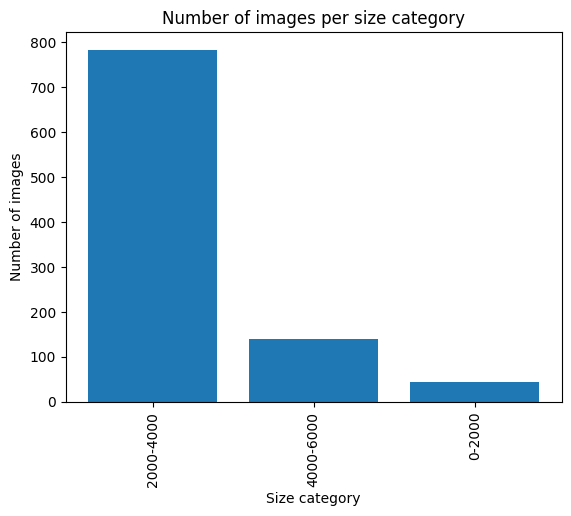

In [95]:
graph_images_size_static(df_metadata, 2000, 3)

# Graph images : size (dynamic)

The function "graph_images_size_dynamic" is used to graph the number of images per size category. It takes a dictionary of metadata as an argument and returns a graph with the number of images per size category. The interval size is calculated dynamically. The number of columns in the graph is 7 by default.

You can choose the type of graph to display (bar, pie or all for both).

In [96]:
def graph_images_size_dynamic(df_meta, nb_intervals=7, graph_type='all'):
    """
    Graph the number of images per size category
    The interval size is calculated dynamically

    :param df_meta: The metadata to graph
    :param nb_intervals: The number of intervals in the graph
    :param graph_type: The type of graph to display (bar, pie or all for both)
    """

    # Calculate the minimum size of each image and store it in a new column
    df_meta['min_size'] = df_meta[['ImageHeight', 'ImageWidth']].min(axis=1)

    # Determine the maximum minimum size and calculate the number of bins dynamically based on the number of columns
    max_min_size = df_meta['min_size'].max()
    num_images = len(df_meta)
    num_bins = int(num_images / (num_images / nb_intervals))

    # Create a list of bins based on the maximum minimum size and number of bins
    bins = [i * (max_min_size / num_bins) for i in range(num_bins + 1)]

    # Create a list of labels for each bin
    labels = [f'{int(bins[i])}-{int(bins[i + 1])}' for i in range(num_bins)]

    # Categorize each image based on its size and bin
    df_meta['size_category'] = pd.cut(df_meta['min_size'], bins=bins, labels=labels)

    # Count the number of images in each category
    size_counts = df_meta['size_category'].value_counts()

    title = 'Number of images per size category'

    # Create the appropriate chart based on the graph type parameter
    if graph_type == 'bar':
        display_bar(title, 'Image size', 'Number of images', size_counts.index, size_counts.values)
    elif graph_type == 'pie':
        display_pie(title, size_counts.values, size_counts.index)
    elif graph_type == 'all':
        display_bar(title, 'Image size', 'Number of images', size_counts.index, size_counts.values)
        display_pie(title, size_counts.values, size_counts.index)

    else:
        raise ValueError('Invalid graph type')


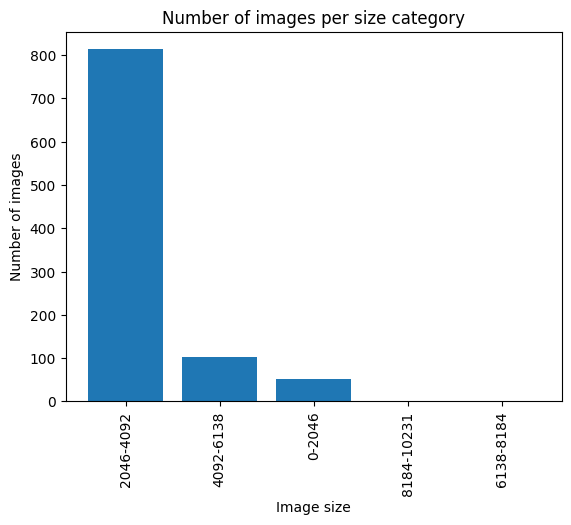

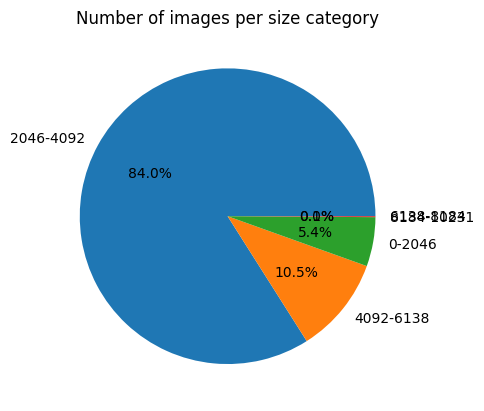

In [97]:
graph_images_size_dynamic(df_metadata, 5, 'all')

# Graph images : DateTime

The function "graph_images_datetime" is used to graph the number of images per year. It takes a dictionary of metadata as an argument and returns a graph with the number of images per year.

You can choose the type of graph to display (bar, pie, curve or all for all).


In [98]:
def graph_images_datetime(df_meta, nb_intervals=10, graph_type='all'):
    """
    Graph the number of images per year

    :param df_meta: The metadata to graph (expects a list of dictionaries)
    :param graph_type: The type of graph to display (bar, pie, curve or all for all)
    :param nb_intervals: The number of intervals to display
    """

    # Extract year from the 'DateTime' column and create a new 'Year' column
    df_meta['Year'] = pd.DatetimeIndex(df_meta['DateTimeOriginal']).year


    # Group the data by year and count the number of images for each year
    image_count = df_meta.groupby('Year').size().reset_index(name='count').sort_values('count', ascending=False)[
                  :nb_intervals]
    image_count['Year'] = image_count['Year'].astype(int)

    # Set the title of the graph
    title = 'Number of images per year'

    # Display different types of graphs based on the 'graph_type' parameter
    if graph_type == 'bar':
        # Display a bar chart
        image_count.plot(kind='bar', x='Year', y='count')
        display_bar(title, 'Year', 'Number of images', image_count['Year'], image_count['count'])

    elif graph_type == 'pie':
        # Display a pie chart using a custom function 'display_pie'
        display_pie(title, image_count['count'], image_count['Year'])

    elif graph_type == 'curve':
        # Display a line chart using a custom function 'display_curve'
        image_count = df_meta.groupby('Year').size().reset_index(name='count').sort_values('Year', ascending=True)
        display_curve(title, 'Year', 'Number of images', image_count['Year'], image_count['count'])

    elif graph_type == 'all':
        # Display all three types of graphs: bar, pie, and line charts

        # Bar chart
        image_count.plot(kind='bar', x='Year', y='count')
        display_bar(title, 'Year', 'Number of images', image_count['Year'], image_count['count'])

        # Pie chart
        display_pie(title, image_count['count'], image_count['Year'])

        # Line chart
        image_count = image_count.sort_values('Year', ascending=True)
        display_curve(title, 'Year', 'Number of images', image_count['Year'], image_count['count'])
    else:
        # Raise an error if an invalid 'graph_type' parameter is passed
        raise ValueError('Invalid graph type')

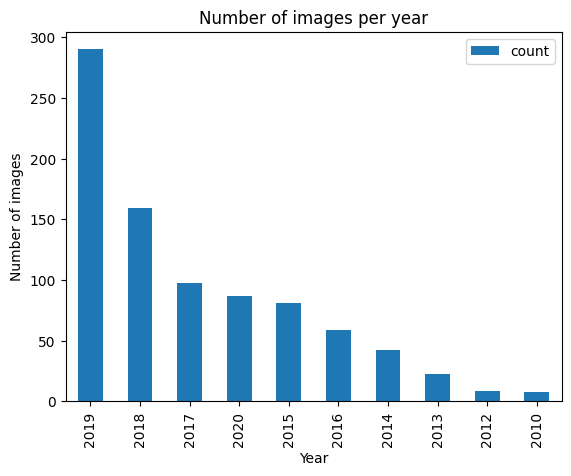

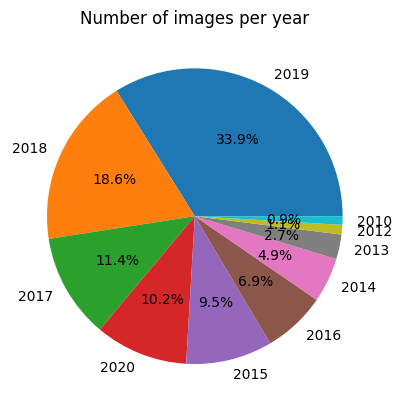

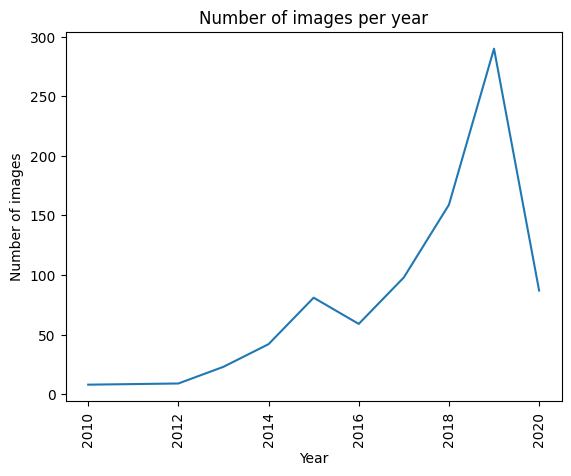

In [99]:
graph_images_datetime(df_metadata, 10, 'all')

# Graph images : Brand

The function "graph_images_brand" is used to graph the number of images per brand. It takes a dictionary of metadata as an argument and returns a graph with the number of images per brand.

You can choose the type of graph to display (bar, pie or all for both), and the number of columns to display.

In [100]:
def graph_images_brand(df_meta, graph_type='all', nb_columns=5):
    """
    Graph the number of images per brand

    :param df_meta: The metadata to graph
    :param graph_type: The type of graph to display (bar, pie or all for both)
    :param nb_columns: The number of columns to display
    """

    # Initialize an empty dictionary to store the counts of each brand
    counts = {}

    # Loop through each brand in the metadata and count the number of occurrences
    for make in df_meta['Make']:
        if make is not None :
            counts[make] = counts.get(make, 0) + 1

    sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

    # Convert the dictionary into two lists of labels and values for graphing
    labels = list(sorted_counts.keys())[:nb_columns]
    values = list(sorted_counts.values())[:nb_columns]

    # Set the title for the graph
    title = 'Number of images per brand'

    # Determine which type of graph to display based on the 'graph_type' parameter
    if graph_type == 'bar':
        # Display a bar graph
        display_bar(title, 'Brand', 'Number of images', labels, values)
    elif graph_type == 'pie':
        # Display a pie chart
        display_pie(title, values, labels)
    elif graph_type == 'all':
        # Display both a bar graph and a pie chart
        display_bar(title, 'Brand', 'Number of images', labels, values)
        display_pie(title, values, labels)
    else:
        # Raise an error if the 'graph_type' parameter is invalid
        raise ValueError('Invalid graph type')

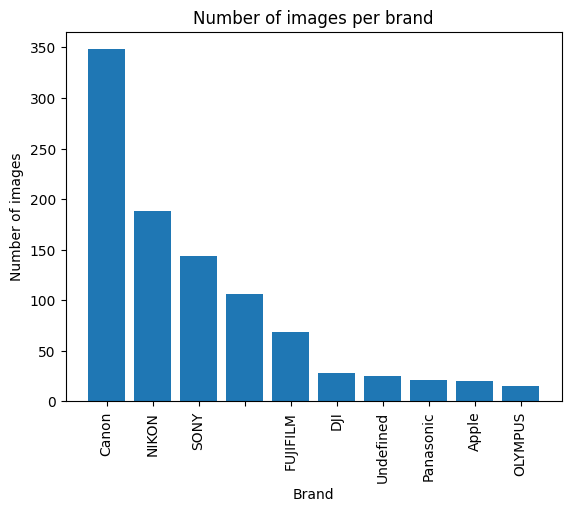

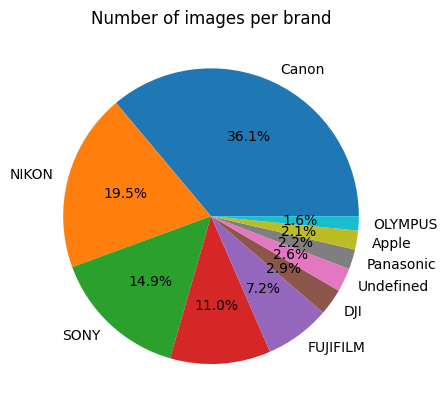

In [101]:
graph_images_brand(df_metadata, 'all', 10)

# Graph images : Images with GPS

#### Overview

The function "gps_info_overview" is used to display the number of images with GPS data. It takes a dictionary of metadata as an argument and returns the number of images with GPS data.

In [102]:
print(f"Number of images with GPS data : {df_metadata['Latitude'].count()}")

Number of images with GPS data : 61


### Extract GPS coordinates

The function "get_coordinates" is used to extract the coordinates of the images with GPS data. It takes a dictionary of metadata as an argument and returns a dictionary with the coordinates of the images with GPS data.

It uses the function "dms_to_dd" to convert the coordinates from DMS (degrees, minutes, seconds) to DD (decimal degrees).

In [103]:
def get_coordinates(df_meta):
    """
    Extract the coordinates of the images with GPS data

    :param df_meta: The metadata to extract the coordinates from
    """
    coords = {}
    for file, lattitude, longitude, altitude in zip(
            df_meta['filename'],
            df_meta['Latitude'],
            df_meta['Longitude'],
            df_meta['Altitude']
    ):
        if lattitude is not None and not np.isnan(lattitude) \
            and longitude is not None and not np.isnan(longitude):
            coords.update({file: [lattitude, longitude, altitude]})

    return coords

In [104]:
coordinates = get_coordinates(df_metadata)

### Using a Map with markers

The function "display_coordinates_on_map" is used to display the coordinates of the images with GPS data on a map. It takes a dictionary of coordinates as an argument and returns a map with the coordinates displayed as markers.

Inside the method comments, you can find a way to display the images as markers instead of the default markers.

In [105]:
def display_coordinates_on_map(coordinates_list):
    """
    Display the coordinates on a map

    :param coordinates_list: The coordinates to display
    :return: The map with the coordinates displayed as markers
    """

    # create a map centered at a specific location
    m = folium.Map(location=[0, 0], zoom_start=1)

    # add markers for each set of coordinates
    for image, coords in coordinates_list.items():
        lat, lon, alt = coords

        # Create a marker with the image as the icon
        # !warning! : the image must be download and you need to add :
        # from folium.features import CustomIcon

        # image_path = '../output/images/' + key
        # icon = CustomIcon(icon_image=image_path, icon_size=(100, 100))
        # folium.Marker(location=coord, icon=icon).add_to(m)
        folium.Marker(location=[lat, lon], tooltip=image, popup=f'file:{image}\ncoord:{coords}').add_to(m)
    return m

In [106]:
display_coordinates_on_map(coordinates)

### Using graphs by country

#### get country

The function "get_country" is used to get the country of each coordinate. It takes a dictionary of coordinates as an argument and returns a dictionary with the coordinates and the country.

In [107]:
def get_country(coordinates_list):
    """
    Get the country of each coordinate

    :param coordinates_list: The coordinates to get the country from
    :return: The coordinates with the country added
    """
    # Create a geolocator
    geolocator = Nominatim(user_agent="geoapiExercises")

    # Get the continent information for each coordinate
    for key, coord in tqdm(coordinates_list.items(), desc='Getting country information'):
        if len(coord) < 4:  # If the country hasn't been found yet
            try:
                location = geolocator.reverse(coord, exactly_one=True, language='en')
                address = location.raw['address']
                country = address.get('country')
                coordinates[key].append(country)
            except:
                print(f"Error with {key} : {coord}")

get_country(coordinates)

Getting country information:  23%|██▎       | 14/61 [00:06<00:22,  2.12it/s]

Error with image_29.jpg : [22.0, 63.0, '63']


Getting country information:  30%|██▉       | 18/61 [00:08<00:20,  2.10it/s]

Error with image_358.jpg : [0.0, 63.0, '63']


Getting country information:  56%|█████▌    | 34/61 [00:16<00:13,  2.06it/s]

Error with image_606.jpg : [75.0, 63.0, '63']


Getting country information:  69%|██████▉   | 42/61 [00:20<00:09,  2.04it/s]C:\Users\woloz\scoop\apps\python37\current\lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


Error with image_735.jpg : [94.0, 63.0, '63']


Getting country information:  77%|███████▋  | 47/61 [00:22<00:06,  2.28it/s]

Error with image_766.jpg : [0.0, 63.0, '63']


Getting country information:  95%|█████████▌| 58/61 [00:28<00:01,  2.05it/s]

Error with image_938.jpg : [0.13333333333333333, 0.0, '0.000000']


Getting country information: 100%|██████████| 61/61 [00:29<00:00,  2.04it/s]


### Display graphs

The function "graph_images_countries" is used to display graphs about the number of images by country. It takes a dictionary of coordinates as an argument and returns a graph.

The parameter "nb_inter" is used to set the number of interval to display. The parameter "graph" is used to set the type of graph to display (bar, pie, all).

In [108]:
def graph_images_countries(coord_list, nb_inter=5, graph='all'):
    """
    Display graphs about the number of images by country

    :param coord_list: list of coordinates
    :param nb_inter: number of interval
    :param graph: type of graph to display (bar, pie, all)
    """

    # Create a pandas DataFrame from the coordinates dictionary
    df = pd.DataFrame.from_dict(coord_list, orient='index',
                                columns=['Latitude', 'Longitude', 'Altitude', 'Country'])

    # Group the DataFrame by continent and count the number of images
    country_count = df.groupby('Country')['Country'].count()
    country_count = country_count.sort_values(ascending=False)[:nb_inter]

    title = 'Number of images by country'

    if graph == 'bar':
        display_bar(title, "Country", "Image Count", country_count.index, country_count.values)
    elif graph == 'pie':
        display_pie(title, country_count.values, country_count.index)
    else:
        display_bar(title, "Country", "Image Count", country_count.index, country_count.values)
        display_pie(title, country_count.values, country_count.index)

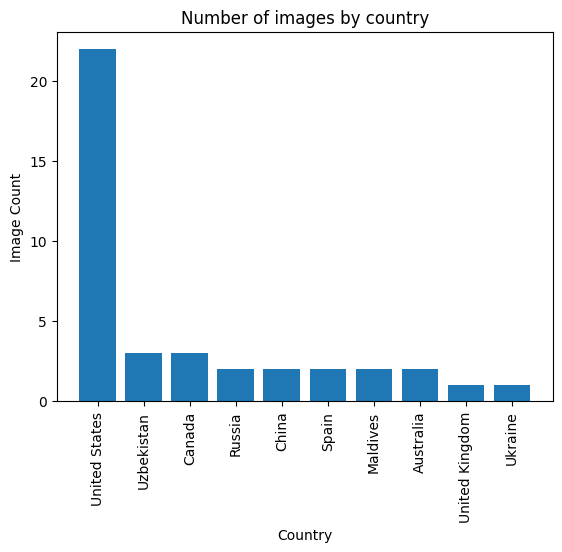

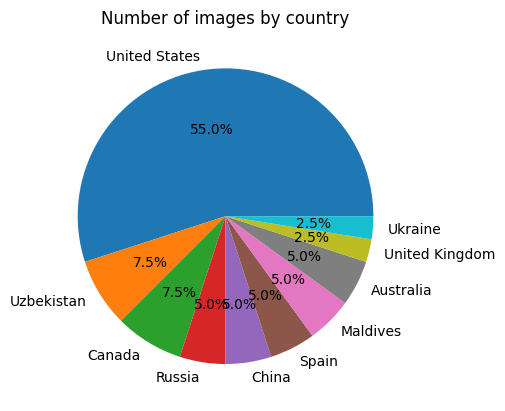

In [109]:
graph_images_countries(coordinates, 10, 'all')

In [162]:
def graph_images_altitudes(coord_list, nb_inter=5, graph='all'):
    """
    TODO

    :param coord_list: list of coordinates
    :param nb_inter: number of interval
    :param graph: type of graph to display (histogram, pie, all)
    """

    altitudes = []
    for img in coord_list:
        alt = float(coord_list[img][2])
        if alt > 0.0:
            altitudes.append(alt)

    # Créer les intervalles en utilisant linspace() de numpy
    intervalles = np.linspace(0, max(altitudes), nb_inter+1)

    # Convertir les intervalles en paires d'intervalles
    intervalles = [(int(intervalles[i]), int(intervalles[i+1])) for i in range(len(intervalles)-1)]

    # Compte combien d'altitudes se situent dans chaque intervalle
    counts = [0] * len(intervalles)
    for altitude in altitudes:
        for i, intervalle in enumerate(intervalles):
            if intervalle[0] <= altitude < intervalle[1]:
                counts[i] += 1

    # Créer une liste de noms pour les intervalles
    noms_intervalles = ["{}-{}".format(intervalle[0], intervalle[1]) for intervalle in intervalles]

    title = 'Number of images by altitude'

    if graph == 'histogram':
        display_histogram(title, "Altitude", "Image Count", altitudes, nb_inter)
    elif graph == 'pie':
        display_pie(title, counts, noms_intervalles)
    elif graph == 'bar':
        display_bar(title, "Altitude", "Image Count", noms_intervalles, counts)
    else:
        display_histogram(title, "Altitude", "Image Count", altitudes, nb_inter)
        display_bar(title, "Altitude", "Image Count", noms_intervalles, counts)
        display_pie(title, counts, noms_intervalles)

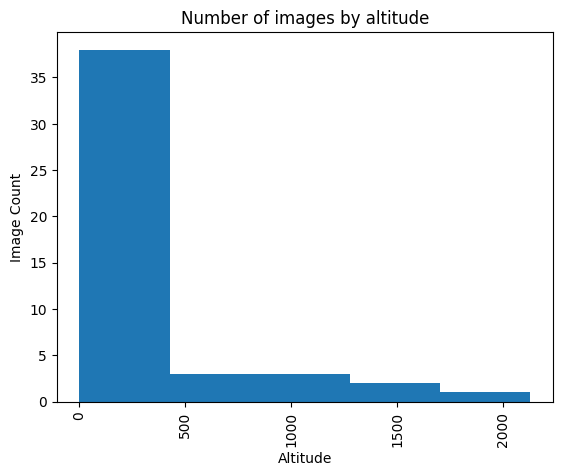

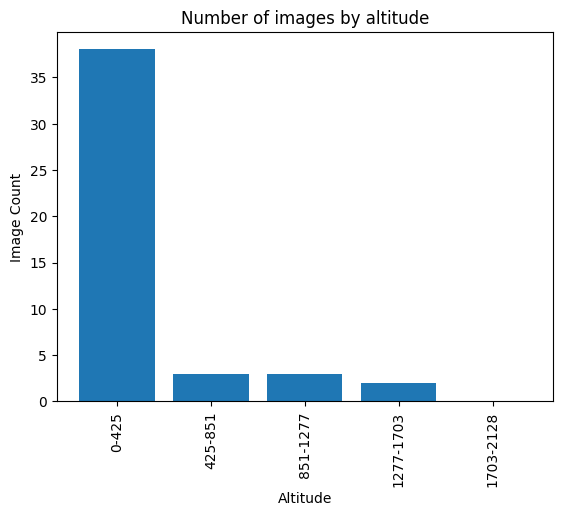

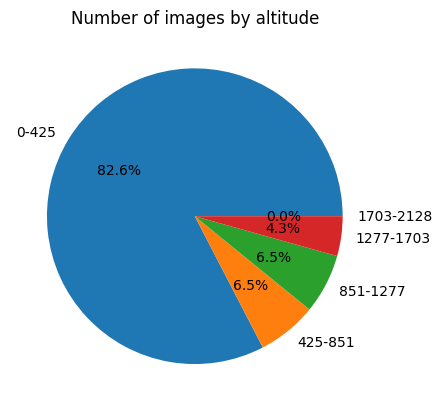

In [163]:
graph_images_altitudes(coordinates, 5, 'all')

# Graph images : by Dominant Color

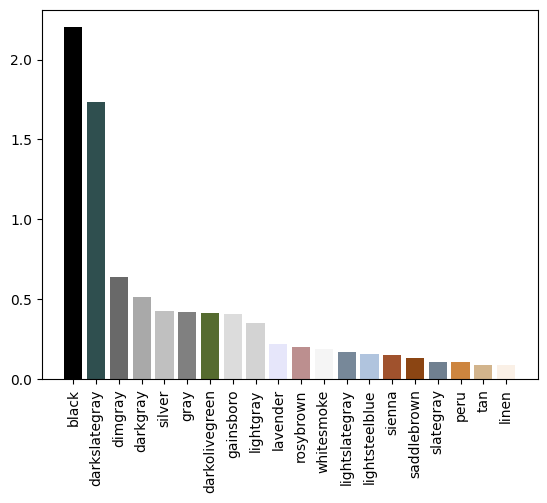

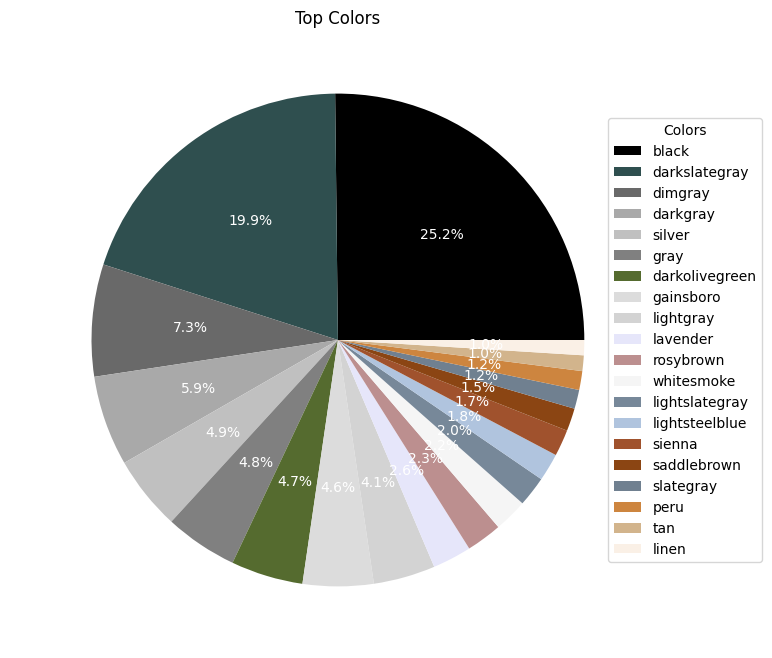

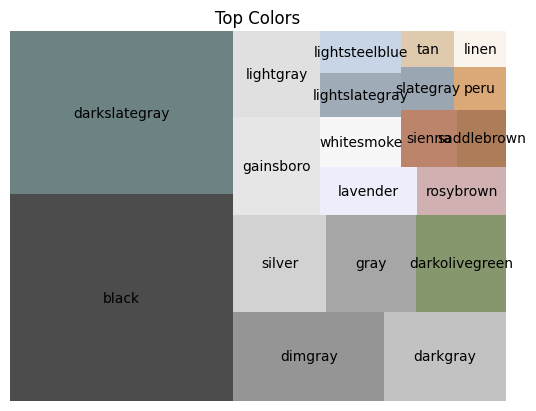

In [164]:
# TODO: Dict ?
MAX_COLUMNS = 20

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name


dict_dom_color = {}
df_dict_meta = df_metadata["dominant_color"].to_dict();

for img in df_dict_meta:
    try :
        if df_dict_meta[img] is not None and df_dict_meta[img] is not np.nan:
            list_dom_color = eval(df_dict_meta[img])
            dict_dom_color.update({ img : list_dom_color })
    except:
        print(f"Error with {img} : {df_dict_meta[img]}")

color_counts = Counter()
for image_colors in dict_dom_color.values():
    for color, percentage in image_colors:
        color_counts[color] += percentage

# Map hexadecimal codes to color names
color_names = {}
for code in color_counts.keys():
    try:
        rgb = webcolors.hex_to_rgb(code)
        actual, closest = get_colour_name(rgb)
        color_names[code] = closest
    except ValueError:
        pass

dict_res = {}
for key, val in color_names.items():
    if val in dict_res:
        dict_res[val] += round(color_counts[key] / 100, 5)
    else:
        dict_res[val] = round(color_counts[key] / 100, 5)

if sum(dict_res.values()) > 100:
    raise Exception('sum of dict_res.values() > 100')

columns = dict_res.__len__()
if columns > MAX_COLUMNS:
    columns = MAX_COLUMNS

sorted_colors = sorted(dict_res.items(), key=lambda x: x[1], reverse=True)
top_colors = dict(sorted_colors[:columns])

# Create a bar graph showing the dominant colors in the images
plt.bar(top_colors.keys(), top_colors.values(), color=top_colors.keys())
plt.xticks(rotation=90)
plt.show()

# Create a pie chart showing the dominant colors in the images
fig, ax = plt.subplots(figsize=(8, 8))
colors = list(top_colors.keys())
ax.pie(top_colors.values(), labels=top_colors.keys(), autopct='%1.1f%%', colors=colors, textprops={'color': 'white'})
ax.set_title('Top Colors')
ax.legend(title='Colors', loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.show()

# Create a treemap showing the dominant colors in the images
color = [webcolors.name_to_hex(c) for c in top_colors]
labels = list(top_colors.keys())
sizes = list(top_colors.values())
squarify.plot(sizes=sizes, label=labels, color=color, alpha=.7)
plt.title("Top Colors")
plt.axis('off')
plt.show()









# Graph images : by Tags

In [ ]:
# convert tag strings to a list of tags
# convert tag strings to a list of tags
#tags = list(itertools.chain.from_iterable([ast.literal_eval(t) for t in dict_metadata['tags']]))

tags = dict_metadata['tags']
# flatten the list of tags
tags = [item for sublist in tags for item in sublist]

# count the occurrences of each tag
tag_counts = Counter(tags)

# plot the most common tags
n = 10
top_tags = dict(tag_counts.most_common(n))
plt.bar(top_tags.keys(), top_tags.values())
plt.title(f"Top {n} most common tags")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


In [ ]:
tags = dict_metadata['tags']
# flatten the list of tags
tags = [item for sublist in tags for item in sublist]

try:
    nlp = spacy.load("en_core_web_lg")  # load pre-trained word embedding model
except OSError:
    !python -m spacy download en_core_web_lg

categories = {
    "landscape": {}, "animal": {}, "people": {}, "food": {}, "building": {}, "vehicle": {}, "object": {}, "other": {}
}

# categorize words based on similarity to category prototypes
for word in tags:
    # find the most similar category prototype for the word
    max_similarity = -1
    chosen_category = "other"
    for category in categories:
        similarity = nlp(word).similarity(nlp(category))
        if similarity > max_similarity:
            max_similarity = similarity
            chosen_category = category

    # add the word into the appropriate category dictionary
    categories[chosen_category].update({word: max_similarity})

print(categories)

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np


# Convert the dictionary into a numpy array
# Convert the dictionary into a numpy array
def dict_to_array(categories):
    n_categories = len(categories)
    arr = np.zeros((n_categories, n_categories))
    for i, (cat, subcat) in enumerate(categories.items()):
        for j, (subcat, val) in enumerate(subcat.items()):
            if j < n_categories:
                arr[i, j] = val
    return arr


# Generate the linkage matrix
Z = linkage(dict_to_array(categories), 'ward')

# Plot the dendrogram
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z, labels=list(categories.keys()))
plt.show()